# Lab6 DBSCAN

This week's exercise will focus on density-based clustering using DBSCAN

Schedule:
* Implement the core of DBSCAN
* Clustering visualizations

In [1]:
# ! git pull

In [2]:
# Makes matplotlib plots work better with Jupyter
%matplotlib inline

# Import the necessary libraries. 
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.datasets import make_moons
from sklearn.cluster import KMeans, DBSCAN
from collections import deque

pd.options.mode.chained_assignment = None

## Take a look at the data

In [3]:
# generate 2d moons dataset
X, _ = make_moons(n_samples=100, noise=0.1)
data = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1]))

features = ['x0', 'x1']

print(data.columns)

Index(['x0', 'x1'], dtype='object')


In [4]:
# Standardize features
data[features] = data[features].sub(data[features].mean(axis=0)).divide(data[features].std(axis=0))

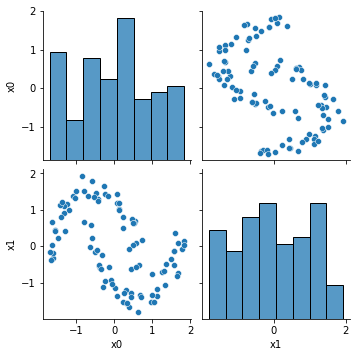

In [5]:
sns.pairplot(data, vars=features)

The scatter plot gives us a visual overview of the possible clusters. Let's see what happens when we try to partition the data with K-means (implemented in `sklearn.clusters`). Let's set K to 2.

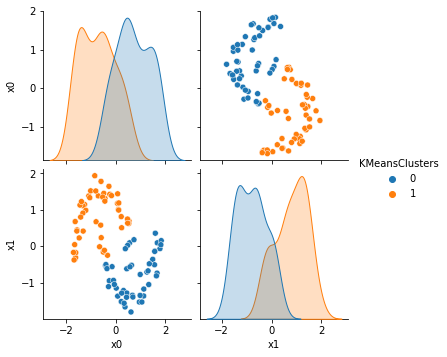

In [6]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(data[features])
data['KMeansClusters'] = pd.Series(kmeans.labels_)

sns.pairplot(data, vars=features, hue='KMeansClusters')

We can see that *K-Means* is not an appropriate clustering algorithm for this kind of dataset. Let's try to use **DBSCAN**, a density-based algorithm, and see if we can achieve better results.

**Spoiler: We will**

In [7]:
# You might want to play around with the parameters "epsilon" and "min_samples" and see which results you can get
DBSCANClustering = DBSCAN(eps=0.4, min_samples=4).fit(data[features])
data['DBSCANClusters'] = pd.Series(DBSCANClustering.labels_)

clusterNames = data['DBSCANClusters'].unique()
clusterNames.sort()

n_clusters = len(clusterNames)

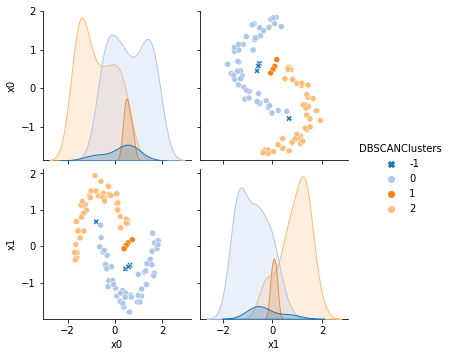

In [8]:
# Use circles for clusters ("o") and crosses for outliers ("x")
markers = ["o"] * (n_clusters)
if clusterNames[0] == -1:
    markers[0] = "X"

sns.pairplot(data, vars=features, hue='DBSCANClusters', palette=sns.color_palette("tab20", n_clusters), markers=markers)

In [9]:
# Let's go back to the original data:
data = data.drop('KMeansClusters', axis=1)
data = data.drop('DBSCANClusters', axis=1)
data.head()

,x0,x1
0,0.677789,-1.345786
1,0.379778,-1.667479
2,-0.786314,0.673488
3,0.318345,-1.215548
4,0.956063,-1.532411


# DBSCAN - todotodotodotodotodotodotodotodotodotodotodo

1. standardize fields (Reminder: subtract by mean, then divide by standard deviation)
2. create K random centroids as arrays with size the number of features
3. foreach `datapoint` in `data`:
  1. set as `centroid` of `datapoint` the closest `centroid`
  2. if at least one `centroid` has changed: goto 3
  
### Tips
- the computations needed for k-means are expensive, test on a small subset of the data to save time (5/10 to check calculations on single rows, 50/100 to check the correctness of the whole algorithm)
- you'll need to compute a distance at a certain point, check Lab3
- [DataFrame.idxmin](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.idxmin.html]) will give you the index of the smallest entry in a dataset
- `dataFrame1 is dataFrame2` is not correct (it checks if the two objects are the same, not if they contain the same values). The correct approach is `dataFrame1.equals(dataFrame2)` (or `dataFrame1['aColumn'].equals(dataFrame2['aColumn'])` ;))
- You can apply a function to every element/row/column of a dataframe by using the `apply` pandas function
- To update the values of the centroids, you might find the combination of `groupby` and `mean` to be useful.
### Reminders:
- Euclidian Distance:
$$ d_e(a, b) = \sqrt{\sum_{i=1}^m{{(a_i-b_i)}^2}}$$
- Minkowski Distance:
$$ d_m(a, b) = \sqrt[q]{\sum_{i=1}^m{{\lvert a_i-b_i \rvert}^q}}$$
- Chebyshev Distance:
$$ d_c(a, b) = \max(\lvert a_1-b_1 \rvert, \lvert a_2-b_2 \rvert, ..., \lvert a_m-b_m \rvert)$$

In [10]:
def DBSCAN(data, eps=0.25, min_samples=3):
    
    visited = set()
    toVisitQueue = deque()
    
    # Initialize every point as noise (Cluster = -1, Core = False)
    data = data.assign(Cluster=pd.Series([-1] * len(data)), Core=pd.Series([False] * len(data)))
    
    currentCluster = 0
    
    def neighboursOf(x):
        ## YOUR CODE HERE
        neighbours = data[features].sub(x[features]) \
            .pow(2).sum(1).pow(0.5)
        return neighbours.loc[(neighbours <= eps)].index.tolist()
    
    for rowIndex in data.index:
        if not rowIndex in visited:
            toVisitQueue.append(rowIndex)
        else:
            continue
        
        while len(toVisitQueue) > 0:
            currentIndex = toVisitQueue.popleft()
            # print("Current Index:", currentIndex)
            neighbours = neighboursOf(data.loc[currentIndex])
            if(len(neighbours) >= min_samples): # it's a core point
                data.at[currentIndex, 'Cluster'] = currentCluster
                data.at[currentIndex, 'Core'] = True
                # Add neighbours to current cluster
                data.at[neighbours, 'Cluster'] = currentCluster
                # If not visited, add neighbours to the set of points to visit
                for neighbourIndex in neighbours:
                    if not neighbourIndex in visited:
                        visited.add(neighbourIndex)
                        toVisitQueue.append(neighbourIndex)
        if data.at[rowIndex, 'Core']:
            currentCluster += 1
    
    return data

In [14]:
new_data = DBSCAN(data, eps=0.4, min_samples=4)

In [15]:
new_data

,x0,x1,Cluster,Core
0,0.677789,-1.345786,0,True
1,0.379778,-1.667479,0,True
2,-0.786314,0.673488,-1,False
3,0.318345,-1.215548,0,True
4,0.956063,-1.532411,0,True
...,...,...,...,...
95,-0.164609,1.390904,2,True
96,-0.450999,-0.110149,0,True
97,-0.432464,1.239640,2,True
98,0.531644,0.625906,2,True


# Clusters visualization
The most difficult task with clustering is understand if the clustering makes sense and what the clustering means. If the dimensionality is low, a good idea is to use a pairplot and see if the clusters are really close in each slice. The closer they are, the better.

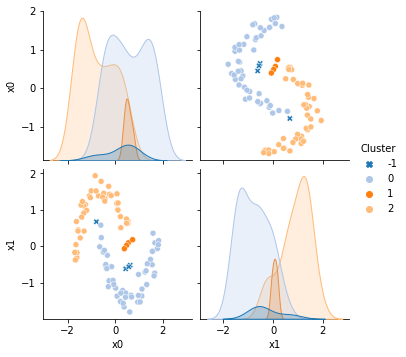

In [16]:
clusterNames = new_data['Cluster'].unique()
clusterNames.sort()
n_clusters = len(clusterNames)

markers = ["o"] * (n_clusters)
if clusterNames[0] == -1:
    markers[0] = "X"

sns.pairplot(new_data, vars=features, hue='Cluster', palette=sns.color_palette("tab20", n_clusters), markers=markers)